## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot
from torchinfo import summary
import numpy as np
from collections import Counter
import os

## Set Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Get & Ready Dataset

In [4]:
def get_balanced_data(dataset, train_size=0.8):
    if isinstance(dataset.targets, torch.Tensor):
        targets = dataset.targets.numpy()
    else:
        targets = np.array(dataset.targets)

    class_counts = Counter(targets)
    min_class_count = min(class_counts.values())
    indices_per_class = {i: [] for i in range(10)}

    for idx, target in enumerate(targets):
        if len(indices_per_class[target]) < min_class_count:
            indices_per_class[target].append(idx)

    all_indices = []
    for cls in indices_per_class:
        all_indices.extend(indices_per_class[cls])

    np.random.shuffle(all_indices)
    train_count = int(len(all_indices) * train_size)
    train_indices = all_indices[:train_count]
    test_indices = all_indices[train_count:]

    return Subset(dataset, train_indices), Subset(dataset, test_indices)

## Plot Function

In [5]:
def plot_loss(losses, dataset_type):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.title(f'Training Loss Curve - {dataset_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'loss_curve_{dataset_type}.png')
    plt.show()
    plt.close()

## CNN Model

In [6]:
class ConvNet(nn.Module):
    def __init__(self, dataset_type='MNIST'):
        super(ConvNet, self).__init__()
        self.dataset_type = dataset_type

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # لایه‌های تمام متصل
        self.fc1 = nn.Linear(64 * 7 * 7, 128)

        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool(self.relu2(self.bn2(self.conv2(x))))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu3(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

## Traning Function

In [7]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    return losses

## Evaluate Function

In [8]:
def evaluate_model(model, loader, dataset_type):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    # رسم ماتریس Confusion
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_type}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'confusion_matrix_{dataset_type}.png')
    plt.show()
    plt.close()

    return acc, f1, cm

## Main Function

In [9]:
def main(dataset_type='MNIST'):
    if dataset_type == 'MNIST':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        input_shape = (1, 28, 28)


    # تقسیم داده‌ها
    train_subset, _ = get_balanced_data(dataset)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=6, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6, pin_memory=True)

    # تعریف مدل
    model = ConvNet(dataset_type=dataset_type).to(device)

    # نمایش خلاصه مدل
    print(f"\nModel Summary for {dataset_type}:")
    summary(model, input_size=(1, *input_shape), device=str(device))

    # معیار و بهینه‌ساز
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # رسم گرافیک شبکه
    sample_input = torch.randn(1, *input_shape).to(device)
    out = model(sample_input)
    graph = make_dot(out, params=dict(model.named_parameters()))
    graph.render(f'network_graph_{dataset_type}', format='png', cleanup=True)

    # آموزش مدل
    losses = train_model(model, train_loader, criterion, optimizer)

    # رسم منحنی Loss
    plot_loss(losses, dataset_type)

    # ارزیابی مدل
    train_acc, train_f1, train_cm = evaluate_model(model, train_loader, f'{dataset_type}_Train')
    test_acc, test_f1, test_cm = evaluate_model(model, test_loader, f'{dataset_type}_Test')

    print(f'\n{dataset_type} Results:')
    print(f'Training Accuracy: {train_acc:.4f}, F1-Score: {train_f1:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}, F1-Score: {test_f1:.4f}')
    print(f'Training Confusion Matrix:\n{train_cm}')
    print(f'Test Confusion Matrix:\n{test_cm}')

## Run ALL

Training on MNIST dataset...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Model Summary for MNIST:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/25], Loss: 0.2760
Epoch [2/25], Loss: 0.1254
Epoch [3/25], Loss: 0.0992
Epoch [4/25], Loss: 0.0874
Epoch [5/25], Loss: 0.0745
Epoch [6/25], Loss: 0.0701
Epoch [7/25], Loss: 0.0632
Epoch [8/25], Loss: 0.0580
Epoch [9/25], Loss: 0.0567
Epoch [10/25], Loss: 0.0508
Epoch [11/25], Loss: 0.0457
Epoch [12/25], Loss: 0.0456
Epoch [13/25], Loss: 0.0420
Epoch [14/25], Loss: 0.0400
Epoch [15/25], Loss: 0.0372
Epoch [16/25], Loss: 0.0355
Epoch [17/25], Loss: 0.0342
Epoch [18/25], Loss: 0.0315
Epoch [19/25], Loss: 0.0307
Epoch [20/25], Loss: 0.0284
Epoch [21/25], Loss: 0.0290
Epoch [22/25], Loss: 0.0279
Epoch [23/25], Loss: 0.0255
Epoch [24/25], Loss: 0.0250
Epoch [25/25], Loss: 0.0238


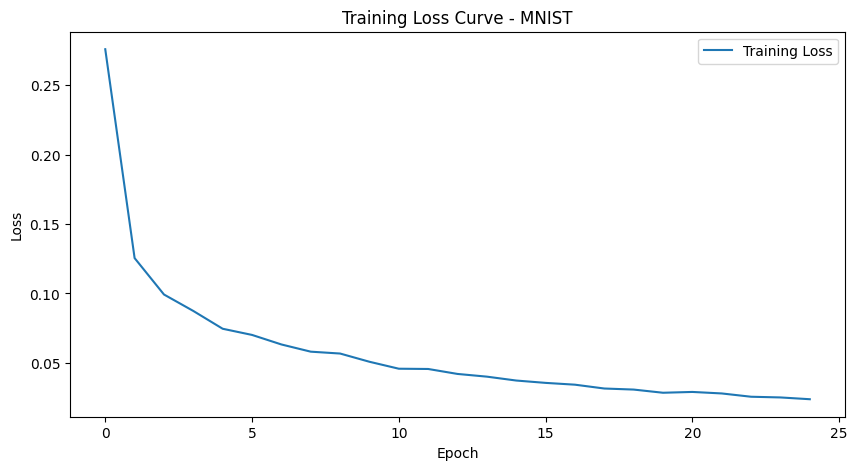

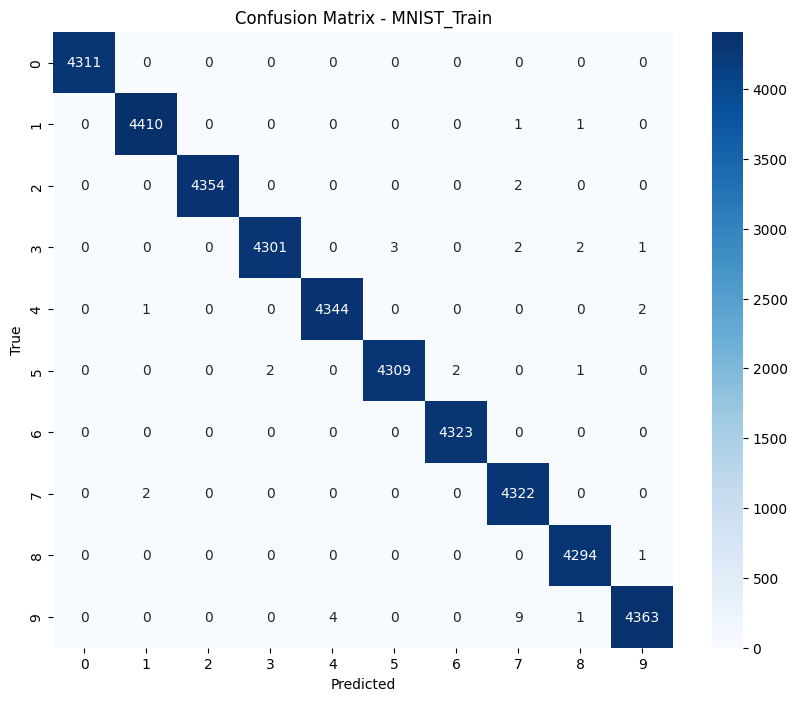

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


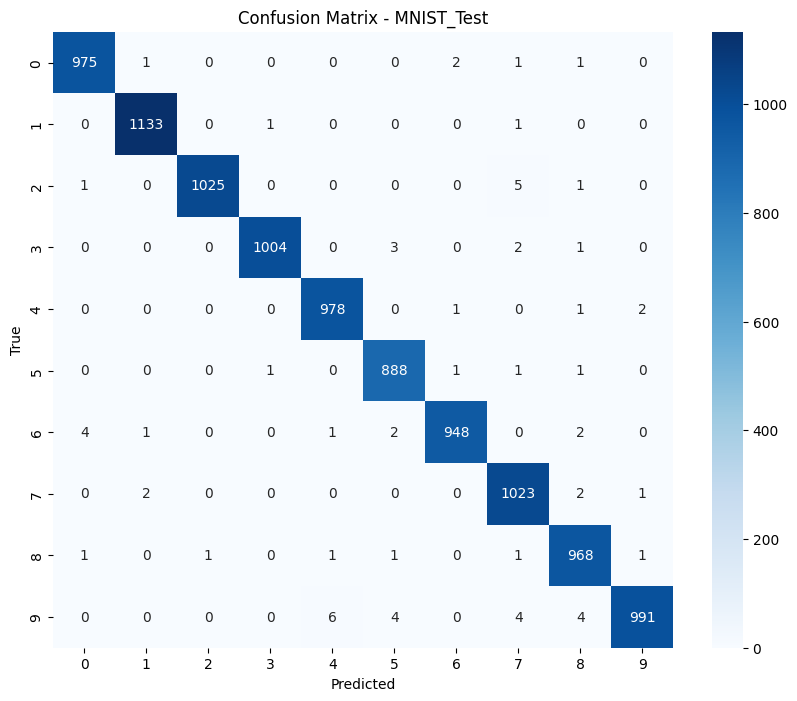


MNIST Results:
Training Accuracy: 0.9991, F1-Score: 0.9991
Test Accuracy: 0.9933, F1-Score: 0.9933
Training Confusion Matrix:
[[4311    0    0    0    0    0    0    0    0    0]
 [   0 4410    0    0    0    0    0    1    1    0]
 [   0    0 4354    0    0    0    0    2    0    0]
 [   0    0    0 4301    0    3    0    2    2    1]
 [   0    1    0    0 4344    0    0    0    0    2]
 [   0    0    0    2    0 4309    2    0    1    0]
 [   0    0    0    0    0    0 4323    0    0    0]
 [   0    2    0    0    0    0    0 4322    0    0]
 [   0    0    0    0    0    0    0    0 4294    1]
 [   0    0    0    0    4    0    0    9    1 4363]]
Test Confusion Matrix:
[[ 975    1    0    0    0    0    2    1    1    0]
 [   0 1133    0    1    0    0    0    1    0    0]
 [   1    0 1025    0    0    0    0    5    1    0]
 [   0    0    0 1004    0    3    0    2    1    0]
 [   0    0    0    0  978    0    1    0    1    2]
 [   0    0    0    1    0  888    1    1    1    0]
 

In [10]:
if __name__ == '__main__':
    try:
        # اجرا برای MNIST
        print("Training on MNIST dataset...")
        main(dataset_type='MNIST')
    except KeyboardInterrupt:
        print("Execution interrupted by user.")